# Partie 1

## 1. Collecte de données

### 1.1 Est-ce que le ratissage des annonces sur le site web que vous avez choisi est permis ? Justifier votre réponse.

In [2]:

import requests
from fake_useragent import UserAgent

ua = UserAgent()

BASE_HTTP = "https://"
URL_DUPROPIO = "duproprio.com"
URL_PUBLIMAI = "www.publimaison.ca"
robots = "/robots.txt"
headers = {
    "User-Agent": f"{ua.random}",
}
response = requests.get(BASE_HTTP + URL_DUPROPIO + robots, headers=headers)
print("duproprio/robots.txt", response.text)

duproprio/robots.txt User-agent: *
Disallow: /email-consent/
Disallow: /facebook/
Disallow: /file/
Disallow: /files/
Disallow: /filesystem/
Disallow: /listing/comparables/
Disallow: /listing/comparable-get-html/
Disallow: /listing/evaluateur-get-html/
Disallow: /listing/modelo/
Disallow: /listing/modelo-get-html/
Disallow: /listing/print/
Disallow: /listing/print-pdf/
Disallow: /listing/report-validate-page
Disallow: /logout
Disallow: /maintenances/
Disallow: /modal/
Disallow: /modelo/
Disallow: /my-account/
Disallow: /pdf-report/
Disallow: /services/
Disallow: /unsupported-browser
Disallow: /util/
Disallow: /validate_dossier.php
Disallow: /webservice/
Disallow: /82591175/
Disallow: /9289347/
Disallow: /browse/listings/all
Disallow: /agent
Disallow: /agents
Disallow: /fr-ca/rest
Disallow: /en-ca/rest
Disallow: /fr-ca/api
Disallow: /en-ca/api
Disallow: /fr/moncompte
Disallow: /en/myaccount

Allow: /*/api-proxy/infosession
Allow: /*/api-proxy/featured-homes
Disallow: /*/api-proxy

Sitema

In [3]:
response = requests.get(BASE_HTTP + URL_PUBLIMAI + robots)
print("publimaison/robots.txt", response.text)

publimaison/robots.txt User-agent: *
Disallow: /fr/achatactivated/
Disallow: /fr/achat/
Disallow: /fr/ajaxrecherche/
Disallow: /fr/alertes/
Disallow: /fr/annoncecreation/
Disallow: /fr/bannieresys/
Disallow: /fr/caisse/
Disallow: /fr/desjardins/
Disallow: /fr/documents/
Disallow: /fr/emprunt/
Disallow: /fr/envoiecourriel/
Disallow: /fr/favoris/
Disallow: /fr/forfait/
Disallow: /fr/gestion*
Disallow: /fr/indicemarche/
Disallow: /fr/listestatistique/
Disallow: /fr/monprofil/
Disallow: /fr/monprofilcourtier/
Disallow: /fr/panier/
Disallow: /fr/promouvoir/
Disallow: /fr/publicite/
Disallow: /fr/sondage/
Disallow: /fr/statistique/
Disallow: /fr/tauxhypothecaire/
Disallow: /fr/statcounter/
Disallow: /fr/Membre/ActivationCompte
Disallow: /fr/Annonce/RafraichirExpiration
Disallow: /fr/transfertcentris/*
Disallow: /en/achatactivated/
Disallow: /en/achat/
Disallow: /en/ajaxrecherche/
Disallow: /en/alertes/
Disallow: /en/annoncecreation/
Disallow: /en/bannieresys/
Disallow: /en/caisse/
Disallow: 

### 1.2 Vous devez extraire dans un fichier .csv a remettre, l’ensemble des annonces (lancer la recherche sans aucun critere)

In [122]:
def extract_characteristics(soup):
    bedrooms = bathrooms = half_baths = floors = living_space = lot_size = None
    characteristics = soup.find('div', class_='listing-main-characteristics')
    if characteristics:
        for item in characteristics.find_all('div', recursive=False):
            label = item.find("div", class_="listing-main-characteristics__label")
            if label:
                title = label.find("span", class_="listing-main-characteristics__title").get_text(strip=True).lower()
                number = label.find("span", class_="listing-main-characteristics__number").get_text(strip=True)
                if "chambre" in title:
                    bedrooms = number
                elif "bain" in title:
                    bathrooms = number
                elif "eau" in title:
                    half_baths = number
                elif "étage" in title:
                    floors = number
        if living_space_element := characteristics.find('div',
                                                        class_='listing-main-characteristics__item--living-space-area'):
            living_space = living_space_element.find('span',
                                                     class_='listing-main-characteristics__number--dimensions').get_text(
                strip=True)

        if lot_size_element := characteristics.find('div', class_='listing-main-characteristics__item--lot-dimensions'):
            lot_size = lot_size_element.find('span',
                                             class_='listing-main-characteristics__number--dimensions').get_text(
                strip=True)

    return bedrooms, bathrooms, half_baths, floors, living_space, lot_size


def extract_mortgage(soup):
    mortgage_div = soup.find("div", class_="mortgage-data__table")
    city_taxes = school_taxes = electricity = insurance = None
    if mortgage_div:
        rows = mortgage_div.find_all("div", class_="mortgage-data__table__row")
        for row in rows:
            name_item = row.find("div", class_="mortgage-data__table__row__item--name")
            if name_item:
                name = name_item.get_text(strip=True).lower()
                value = row.find("div", class_="mortgage-data__table__row__item--yearly-costs").get_text(strip=True)
                if "taxes municipales" in name:
                    city_taxes = value
                elif "taxes scolaires" in name:
                    school_taxes = value
                elif "électricité" in name:
                    electricity = value
                elif "assurances" in name:
                    insurance = value
    return city_taxes, school_taxes, electricity, insurance


def extract_data_from_item(response):
    soup = BeautifulSoup(response.text, "html.parser")
    address_div = soup.find("div", class_="listing-location__address")
    address = address_div.find("h1").get_text(strip=True) if address_div and address_div.find("h1") else None
    city = address_div.find_all("span")[0].get_text(strip=True) if address_div and len(
        address_div.find_all("span")) > 0 else None
    region = address_div.find_all("span")[1].get_text(strip=True) if address_div and len(
        address_div.find_all("span")) > 1 else None
    price_div = soup.find("div", class_='listing-price__amount')
    price = price_div.get_text(strip=True) if price_div else None
    bedrooms, bathrooms, half_baths, floors, living_space, lot_size = extract_characteristics(soup)
    city_taxes, school_taxes, electricity, insurance = extract_mortgage(soup)
    return {
        "Adresse": address,
        "Prix": price,
        "Ville": city,
        "Région": region,
        "Chambres": bedrooms,
        "Salles de bain": bathrooms,
        "Salles d'eau": half_baths,
        "Étages": floors,
        "Aire habitable": living_space,
        "Taille terrain": lot_size,
        "Taxes municipales": city_taxes,
        "Taxes scolaires": school_taxes,
        "Électricité": electricity,
        "Assurances": insurance
    }

In [129]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import logging
import pandas as pd
import traceback

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
columns = ["Adresse", "Prix", "Ville", "Région", "Chambres", "Salles de bain", "Salles d'eau", "Étages",
           "Aire habitable", "Taille terrain", "Taxes municipales", "Taxes scolaires", "Électricité", "Assurances"]
filename = "../data/duproprio.csv"
scrap_data = []
session = requests.Session()
session.headers.update(headers)

try:
    logging.info("Début de la collecte des données")
    for page_number in tqdm(range(1, 714), desc="Pages", leave=True):
        url = f"https://duproprio.com/fr/rechercher/liste?search=true&parent=1&pageNumber={page_number}&sort=-published_at"
        response = session.get(url, headers=headers)
        if response.status_code != 200:
            logging.error(f"Erreur lors de la requete {url} : {response.status_code}")
            break
        soup = BeautifulSoup(response.text, "html.parser")
        listings = soup.find_all("li", class_="search-results-listings-list__item")
        for item in listings:
            if "ad-zone" in item.get("class", []):
                continue
            url = item.find("a", class_="search-results-listings-list__item-image-link").get("href")
            response = session.get(url, headers=headers)
            scrap_data.append(extract_data_from_item(response))
    logging.info("Fin de la collecte des données")
except Exception as e:
    logging.error(f"Erreur : {e} \n {traceback.format_exc()}")

if len(scrap_data):
    try:
        logging.info("Début de l'écriture des données")
        df = pd.DataFrame(scrap_data, columns=columns)
        df.to_csv(filename, index=False)
        logging.info("Fin de l'écriture des données")
    except Exception as e:
        logging.error(f"Erreur : {e}")


2023-11-15 01:39:57,797 - INFO - Début de la collecte des données


Pages:   0%|          | 0/713 [00:00<?, ?it/s]

2023-11-15 02:36:41,433 - INFO - Fin de la collecte des données
2023-11-15 02:36:41,435 - INFO - Début de l'écriture des données
2023-11-15 02:36:41,568 - INFO - Fin de l'écriture des données


## 2. Nettoyage et exploration des donnees
### 2.1 Combien ya-t-il de valeurs manquantes dans chaque colonne de votre jeu de donn´ees?

In [2]:
import pandas as pd

df = pd.read_csv('../data/duproprio.csv')
df.isnull().sum()

Adresse               285
Prix                   68
Ville                   0
Région                  0
Chambres             1378
Salles de bain       1452
Salles d'eau         5036
Étages               2093
Aire habitable       2444
Taille terrain       1359
Taxes municipales    2170
Taxes scolaires      2564
Électricité          4126
Assurances           5241
dtype: int64

### 2.2 Selon vous, quel est la cause de ces valeurs manquantes ? Est-ce que parmi les colonnes qui ont des valeurs manquantes, on pourrait utiliser l’une des techniques de remplacement de valeurs manquantes vues en cours ? Si oui dites pour les colonnes concern´ees, lesquelles des techniques fonctionneraient bien


In [3]:
df.isnull().sum().apply(lambda x: x / df.shape[0] * 100)

Adresse               3.637524
Prix                  0.867900
Ville                 0.000000
Région                0.000000
Chambres             17.587747
Salles de bain       18.532227
Salles d'eau         64.275686
Étages               26.713465
Aire habitable       31.193363
Taille terrain       17.345246
Taxes municipales    27.696235
Taxes scolaires      32.724952
Électricité          52.661136
Assurances           66.892151
dtype: float64

Il y a plusieurs valeurs manquantes pour diverse raison : 
- Données optionnelles comme les taxes et les assurances par exemple
- Données non pertinentes comme la taille du terrain ou le nombre d'étages pour un appartement
- Données non disponible depuis la source de données

Pour les chambres, salle de bain, salle d'eau, et etages :
- Inference : Remplacer les valeurs manquantes par le mode pourrait etre une bonne solution car ce sont des variables discrete
- Regression : Remplacer les valeurs manquantes via une regression serait une bonne solution si on arrive a demontrer une correlation entre les variables par exemple avec la surface habitable.

Pour l'aire habitable et la taille du terrain :
- Inference : Remplacer les valeurs manquantes par la mediane ou la moyenne pourrait etre une bonne solution car ce sont des variables continue, il faudrait voir la courbe de distribution pour choisir la bonne methode. Si la distribution est asymetrique, la mediane est plus appropriee.
- Regression : Remplacer les valeurs manquantes via une regression serait une bonne solution si on arrive a demontrer une correlation entre les variables par exemple avec le prix.

Pour les taxes municipales, taxes scolaires, electricite et assurances :
- Inference : Remplacer les valeurs manquantes par la moyenne ou la medianne est une solution envisageable car ce sont des variables continue, on pourrait voir s'il y a une certaine proportions avec la valeur du bien et la taille du terrain par exemple.

Pour le prix: 
- Suppresion: Supprimer les lignes ou le prix est manquante pourrait etre une bonne solution car cela ne represente seulement que 0.94% des donnees.

Pour l'adresse :
- Supression: Ayant la ville et la region, on pourrait supprimer l'adresse. Puis difficelement remplacable.

### 2.3 Combien ya til de r´egions diff´erentes ? et de villes diff´erentes ?

In [4]:
unique_regions = df["Région"].unique()
print(f"Nombre de regions differentes : {len(unique_regions)}")
unique_cities = df["Ville"].unique()
print(f"Nombre de villes differentes : {len(unique_cities)}")

Nombre de regions differentes : 21
Nombre de villes differentes : 993


### 2.4 Quel est le type (inf´er´e par pandas) de donn´ees de chaque colonne ?

In [5]:
df.dtypes

Adresse               object
Prix                  object
Ville                 object
Région                object
Chambres             float64
Salles de bain       float64
Salles d'eau         float64
Étages               float64
Aire habitable        object
Taille terrain        object
Taxes municipales     object
Taxes scolaires       object
Électricité           object
Assurances            object
dtype: object

### 2.5 Nettoyer vos donn´ees : correction d’erreurs, traitement de valeurs manquantes s’il ya lieu, correction du type des donn´ees.

In [16]:
df.dtypes

Adresse               object
Prix                 float64
Ville                 object
Région                object
Chambres             float64
Salles de bain       float64
Salles d'eau         float64
Étages               float64
Aire habitable       float64
Taille terrain       float64
Taxes municipales    float64
Taxes scolaires      float64
Électricité          float64
Assurances           float64
dtype: object

In [9]:
import re


def convert_price(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, float):
        return value
    try:
        return float(value.replace("$", "").replace('\xa0', '').replace(',', '.').strip())
    except ValueError:
        return np.nan


def convert_surface(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, float):
        return value
    try:
        value = value.replace(' ', '')
        if 'x' in value or 'X' in value:
            m2 = re.search(r'(\d+(\.\d+)?)\s*[xX]\s*(\d+(\.\d+)?)\s*[mM]', value)

            if m2:
                return float(m2.group(1)) * float(m2.group(3))

        m2 = re.search(r'(\d+(\.\d+)?)\s*[mM]', value)
        if m2:
            return float(m2.group(1))

        acres = re.search(r'(\d+(\.\d+)?)\s*acre', value, re.IGNORECASE)
        if acres:
            return float(acres.group(1)) * 4046.86

        hectares = re.search(r'(\d+(\.\d+)?)\s*hectare', value, re.IGNORECASE)
        if hectares:
            return float(hectares.group(1)) * 10000

    except ValueError:
        return np.nan


In [28]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/duproprio.csv')

df['Adresse'].fillna('', inplace=True)

df['Prix'] = df['Prix'].apply(convert_price)
df['Taxes municipales'] = df['Taxes municipales'].apply(convert_price)
df['Taxes scolaires'] = df['Taxes scolaires'].apply(convert_price)
df['Électricité'] = df['Électricité'].apply(convert_price)
df['Assurances'] = df['Assurances'].apply(convert_price)

df['Taille terrain'] = df['Taille terrain'].apply(convert_surface)
df['Aire habitable'] = df['Aire habitable'].apply(convert_surface)



In [29]:
# somme des valeurs manquantes pour taille terrain et aire habitable
print(df["Taille terrain"].isna().sum())
print(df["Aire habitable"].isna().sum())

1374
2444


In [30]:
#display where aire habitable is nan or taille terrain is nan
df[(df["Aire habitable"].isna() | df["Taille terrain"].isna())]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances
1,", boulevard Montseigneur-de-Laval",350000.0,Baie-St-Paul,Charlevoix,NaN,NaN,NaN,NaN,NaN,194298.00,359.1,200.0,NaN,NaN
2,"404-1420, rue Gaston-Véronneau",284000.0,Longueuil (Vieux-Longueuil),Montérégie (Rive-Sud Montréal),1.0,1.0,1.0,1.0,61.04,NaN,1797.0,175.0,NaN,NaN
4,"744-746, rue Louis-H Desjardins",635000.0,Terrebonne (Terrebonne),Lanaudière,5.0,3.0,NaN,NaN,NaN,109.98,4257.0,352.0,NaN,NaN
9,Unité 506 - 7480 Boulevard Taschereau,658900.0,Brossard,Montérégie (Rive-Sud Montréal),3.0,2.0,NaN,1.0,109.25,NaN,NaN,NaN,NaN,NaN
10,"63, rue de Bellevue",475000.0,Blainville,Laurentides,NaN,NaN,NaN,NaN,NaN,752.50,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,", boulevard Montseigneur-de-Laval",350000.0,Baie-St-Paul,Charlevoix,NaN,NaN,NaN,NaN,NaN,194298.00,359.1,200.0,NaN,NaN
7826,"404-1420, rue Gaston-Véronneau",284000.0,Longueuil (Vieux-Longueuil),Montérégie (Rive-Sud Montréal),1.0,1.0,1.0,1.0,61.04,NaN,1797.0,175.0,NaN,NaN
7828,"744-746, rue Louis-H Desjardins",635000.0,Terrebonne (Terrebonne),Lanaudière,5.0,3.0,NaN,NaN,NaN,109.98,4257.0,352.0,NaN,NaN
7833,Unité 506 - 7480 Boulevard Taschereau,658900.0,Brossard,Montérégie (Rive-Sud Montréal),3.0,2.0,NaN,1.0,109.25,NaN,NaN,NaN,NaN,NaN


In [31]:
df[df.duplicated()]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances
2614,"656-700, Chemin de la Côte S du Lac Vert",NaN,St-Nérée,Chaudière-Appalaches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4392,"1285, boulevard Arthur-Sauvé",52.0,Laval-Ouest,Laval,NaN,NaN,NaN,NaN,NaN,4065.7200,NaN,NaN,NaN,NaN
4627,rang de Bellechasse,45000.0,St-Magloire-De-Bellechasse,Chaudière-Appalaches,NaN,NaN,NaN,NaN,NaN,15000.0000,NaN,NaN,NaN,NaN
4894,"234, rue de la Station",199500.0,Armagh,Chaudière-Appalaches,5.0,NaN,NaN,NaN,NaN,3716.1200,1400.00,NaN,200.0,NaN
5091,rue du Geai-Bleu,298000.0,St-Apollinaire,Chaudière-Appalaches,5.0,1.0,1.0,2.0,130.81,418.0600,NaN,NaN,NaN,NaN
5434,Rue des Iris,NaN,Victoriaville,Centre-du-Québec,2.0,1.0,NaN,1.0,98.85,1486.4500,NaN,NaN,NaN,NaN
5574,rang Sainte-Anne,41500.0,La Malbaie (St-Fidèle),Charlevoix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5796,"859, chemin Parent",209000.0,La Pêche (Duclos),Outaouais,NaN,NaN,NaN,NaN,NaN,445154.6000,NaN,NaN,NaN,NaN
6748,"1164, route Henderson",35000.0,St-Malachie,Chaudière-Appalaches,NaN,NaN,NaN,NaN,NaN,2800.0000,333.32,NaN,NaN,NaN
7791,"1952, rue des Tulipes",359000.0,Jonquière (Jonquière),Saguenay-Lac-Saint-Jean,3.0,2.0,NaN,1.0,85.21,1040.0500,NaN,NaN,NaN,NaN


In [32]:
df = df.drop_duplicates(subset=['Adresse'], keep='first')
df[df.duplicated()]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances


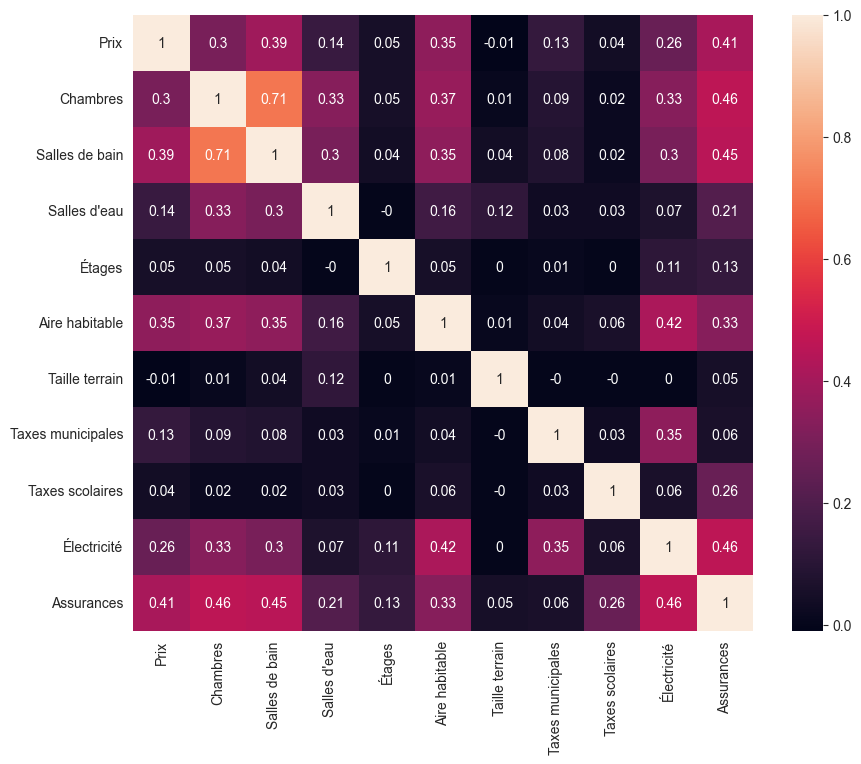

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['float64'])

correlation_matrix = numeric_df.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [34]:
df.isnull().sum().apply(lambda x: x / df.shape[0] * 100)

Adresse               0.000000
Prix                  0.719327
Ville                 0.000000
Région                0.000000
Chambres             17.494571
Salles de bain       18.485342
Salles d'eau         64.237242
Étages               26.886536
Aire habitable       31.392508
Taille terrain       17.290988
Taxes municipales    23.832790
Taxes scolaires      29.044517
Électricité          49.904995
Assurances           65.010858
dtype: float64

In [35]:
import numpy as np


# Maison : Aire habitable, Taille terrain, Chambres, Salles de bain
# Appartement : Aire habitable, Chambres, Salles de bain
# Terrain : Taille terrain
def categorize_property_type(row):
    if not pd.isna(row['Aire habitable']) and not pd.isna(row['Taille terrain']) and (not pd.isna(
            row['Chambres']) or not pd.isna(row['Salles de bain'])):
        return 'Maison'
    elif not pd.isna(row['Aire habitable']) and (not pd.isna(row['Chambres']) or not pd.isna(row['Salles de bain'])):
        return 'Appartement'
    elif not pd.isna(row['Taille terrain']):
        return 'Terrain'
    else:
        return np.nan


df["Type"] = df.apply(categorize_property_type, axis=1)


In [36]:
df[df["Type"].isna()]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances,Type
323,"10-124, rue Lapointe",299000.0,Repentigny (Repentigny),Lanaudière,2.0,1.0,NaN,1.0,NaN,NaN,1711.05,115.92,NaN,NaN,NaN
335,chemin du Gouverneur Duquesne,235000.0,Rivière-à-Pierre,Portneuf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,100 chemin des Diligences,619900.0,Bromont,Estrie,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,"1770, rue du Fief",89000.0,Trois-Rivières (Trois-Rivières),Mauricie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,"653, rue Anne-Hébert",615000.0,Terrebonne (Terrebonne),Lanaudière,3.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,"925, rang 4e Ouest",1799000.0,St-Simon-De-Bagot,Montérégie (Rive-Sud Montréal),4.0,2.0,1.0,2.0,NaN,NaN,3183.00,1203.00,NaN,NaN,NaN
7630,"4654, rue des Samares",399990.0,Charlesbourg,Québec Rive-Nord,2.0,1.0,1.0,2.0,NaN,NaN,2281.00,434.00,95.0,59.0,NaN
7695,"162, rue Harold",595000.0,Gatineau (Gatineau),Outaouais,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7761,"7, rue Lafrance",499000.0,Déléage,Outaouais,NaN,NaN,NaN,NaN,NaN,NaN,3943.56,NaN,NaN,NaN,NaN


In [37]:
before = df.shape[0]
df = df.dropna(subset=['Type'])
after = df.shape[0]
print(f"Nombre de lignes supprimees : {before - after}")

Nombre de lignes supprimees : 150


In [38]:
df = df.astype({"Chambres": "Int64", "Salles de bain": "Int64", "Salles d'eau": "Int64", "Étages": "Int64"})

# fill missing values with 0 where type is terrain
df.loc[df["Type"] == "Terrain", ["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Assurances",
                                 "Électricité"]] = 0

# fill missing values of terrain with 0 for appartement
df.loc[df["Type"] == "Appartement", ["Taille terrain"]] = 0

# fill missing values with the median by type
df["Chambres"].fillna(df.groupby("Type")["Chambres"].transform("median"), inplace=True)
df["Salles de bain"].fillna(df.groupby("Type")["Salles de bain"].transform("median"), inplace=True)
df["Étages"].fillna(df.groupby("Type")["Étages"].transform("median"), inplace=True)
df["Taxes municipales"].fillna(df.groupby("Type")["Taxes municipales"].transform("median"), inplace=True)
df["Taxes scolaires"].fillna(df.groupby("Type")["Taxes scolaires"].transform("median"), inplace=True)
df["Électricité"].fillna(df.groupby("Type")["Électricité"].transform("median"), inplace=True)
df["Assurances"].fillna(df.groupby("Type")["Assurances"].transform("median"), inplace=True)



# fill missing values with 0
df["Salles d'eau"].fillna(0, inplace=True)
 
# prix missing values delete rows
before_rm = df.shape[0]
df.dropna(subset=["Prix"], inplace=True)
after_rm = df.shape[0]
print(f"Nombre de lignes supprimees : {before_rm - after_rm}")

Nombre de lignes supprimees : 41


In [39]:
df

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances,Type
0,"1952, rue des Tulipes",359000.0,Jonquière (Jonquière),Saguenay-Lac-Saint-Jean,3,2,0,1,85.21,1040.0500,2870.31,281.000,1956.0,1142.36,Maison
1,", boulevard Montseigneur-de-Laval",350000.0,Baie-St-Paul,Charlevoix,0,0,0,0,0.00,194298.0000,359.10,200.000,0.0,0.00,Terrain
2,"404-1420, rue Gaston-Véronneau",284000.0,Longueuil (Vieux-Longueuil),Montérégie (Rive-Sud Montréal),1,1,1,1,61.04,0.0000,1797.00,175.000,800.0,478.52,Appartement
3,"1454, rue de Niverville",410000.0,Chambly,Montérégie (Rive-Sud Montréal),2,1,1,1,119.84,18117.9500,2129.00,251.000,507.0,272.00,Maison
4,"744-746, rue Louis-H Desjardins",635000.0,Terrebonne (Terrebonne),Lanaudière,0,0,0,0,0.00,109.9800,4257.00,352.000,0.0,0.00,Terrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,"1810, chemin du Parc",120000.0,Mandeville,Lanaudière,0,0,0,0,0.00,4180.6400,3000.00,285.385,0.0,0.00,Terrain
7783,"847, rue Lavigne",450000.0,Ste-Julienne,Lanaudière,2,1,1,2,102.19,2647.7976,1600.00,340.000,2200.0,1398.00,Maison
7784,"1492, chemin Magenta Ouest",600000.0,Brigham,Estrie,5,2,0,1,118.17,4001.4000,1984.82,486.960,1956.0,800.00,Maison
7786,croissant de la Falaise,6.0,Val-David,Laurentides,0,0,0,0,0.00,2395.0000,687.72,122.510,0.0,0.00,Terrain


In [ ]:
# Modele de regression de remplacment realiser avant que je decide d'ajouter la colonne type


from sklearn.linear_model import LinearRegression

bedrooms = df[df["Chambres"].notna()]
bedrooms_na = df[df["Chambres"].isna()]

X = bedrooms[["Salles de bain"]]
y = bedrooms["Chambres"]

model_bedrooms = LinearRegression()
model_bedrooms.fit(X, y)

X_missing = bedrooms_na[["Salles de bain"]]
predicted_chambres = model_bedrooms.predict(X_missing)
predicted_chambres = predicted_chambres.round().astype(int)
df.loc[df["Chambres"].isna(), "Chambres"] = predicted_chambres

In [41]:
df.isnull().sum().apply(lambda x: x / df.shape[0] * 100)

Adresse              0.0
Prix                 0.0
Ville                0.0
Région               0.0
Chambres             0.0
Salles de bain       0.0
Salles d'eau         0.0
Étages               0.0
Aire habitable       0.0
Taille terrain       0.0
Taxes municipales    0.0
Taxes scolaires      0.0
Électricité          0.0
Assurances           0.0
Type                 0.0
dtype: float64

### 2.6 Quel est le prix moyen des maisons (au moins 1 chambre et 1 salle de bain) sur l’ˆıle de Montr´eal ? A Laval ? Dans les laurentides ?

In [42]:
regions = df["Région"].unique()
print(f"Regions : {regions}")

Regions : ['Saguenay-Lac-Saint-Jean' 'Charlevoix' 'Montérégie (Rive-Sud Montréal)'
 'Lanaudière' 'Bas-Saint-Laurent' 'Estrie' 'Québec Rive-Sud (Lévis)'
 'Laurentides' 'Outaouais' "Montréal / l'Île" 'Québec Rive-Nord'
 'Centre-du-Québec' 'Laval' 'Chaudière-Appalaches' 'Mauricie'
 'Gaspésie-Îles-de-la-Madeleine' 'Portneuf' 'Montérégie Ouest'
 'Abitibi-Témiscamingue' 'Côte-Nord' 'Nord-du-Québec']


In [43]:
mask_houses = (df["Chambres"] >= 1) & (df["Salles de bain"] >= 1)

avg_price_montreal = df[(df["Région"] == "Montréal / l'Île") & mask_houses]["Prix"].mean()
avg_price_laval = df[(df["Région"] == "Laval") & mask_houses]["Prix"].mean()
avg_price_laurentides = df[(df["Région"] == "Laurentides") & mask_houses]["Prix"].mean()

print(f"Prix moyen des maisons sur l'ile de Montreal : {avg_price_montreal}")
print(f"Prix moyen des maisons a Laval : {avg_price_laval}")
print(f"Prix moyen des maisons dans les laurentides : {avg_price_laurentides}")

Prix moyen des maisons sur l'ile de Montreal : 617155.0657939914
Prix moyen des maisons a Laval : 630601.475
Prix moyen des maisons dans les laurentides : 663159.8872545455


### 2.7 Dans quelle ville de Montr´eal/l’Ile les maisons (au moins 1 chambre et 1 salle de bain) coˆutent le moins chers ?

In [44]:
mask_houses_montreal = (df["Région"] == "Montréal / l'Île") & mask_houses

avg_price_by_city = df[mask_houses_montreal].groupby("Ville")["Prix"].mean()

cheaper_city = avg_price_by_city.idxmin()
avg_cheaper_city = avg_price_by_city.min()

print(f"Ville la moins chere : {cheaper_city}")
print(f"Prix moyen des maisons dans la ville la moins chere : {avg_cheaper_city}")

Ville la moins chere : Pointe-Aux-Trembles / Montréal-Est
Prix moyen des maisons dans la ville la moins chere : 451905.2631578947


### 2.8 Pour chaque r´egion, afficher le prix de l’item (annonce) le plus ´elev´e et la ville o`u l’item se situe. Ici on ne fait pas de diff´erence si c’est un condo/appartement, maison, terrain vide, etc. A quel r´egion/ville revient la palme d’or de l’item le plus cher ? Donner toutes les caract´eristiques (valeurs de toutes les colonnes) de cet item.

In [47]:
most_expensive_item_region = df.loc[df.groupby("Région")["Prix"].idxmax()]
print(most_expensive_item_region[["Région", "Ville", "Adresse", "Prix"]])

print("\nItem le plus cher :")
most_expensive_item = df.loc[df["Prix"].idxmax()]
print(most_expensive_item)

                              Région                               Ville  \
200            Abitibi-Témiscamingue                          Senneterre   
3958               Bas-Saint-Laurent   Rimouski (Ste-Odile-Sur-Rimouski)   
222                 Centre-du-Québec                     St-Pie-De-Guire   
3033                      Charlevoix                     Les Éboulements   
4318            Chaudière-Appalaches                           St-Julien   
895                        Côte-Nord                           Sept-Iles   
4304                          Estrie                              Granby   
6544   Gaspésie-Îles-de-la-Madeleine                               Percé   
6125                      Lanaudière             Terrebonne (Terrebonne)   
6007                     Laurentides                        St-Hippolyte   
6760                           Laval                        Duvernay-Est   
7048                        Mauricie         Shawinigan (Shawinigan-Sud)   
6738        

## 3 Visualisation et analyse des donn´ees
### 3.1  Pr´esenter visuellement (`a l’aide d’un graphique) la matrice de corr´elation entre les colonnes num´eriques. Y a-t-il des corr´elations de plus de 0.7 ? quelles sont elles ?

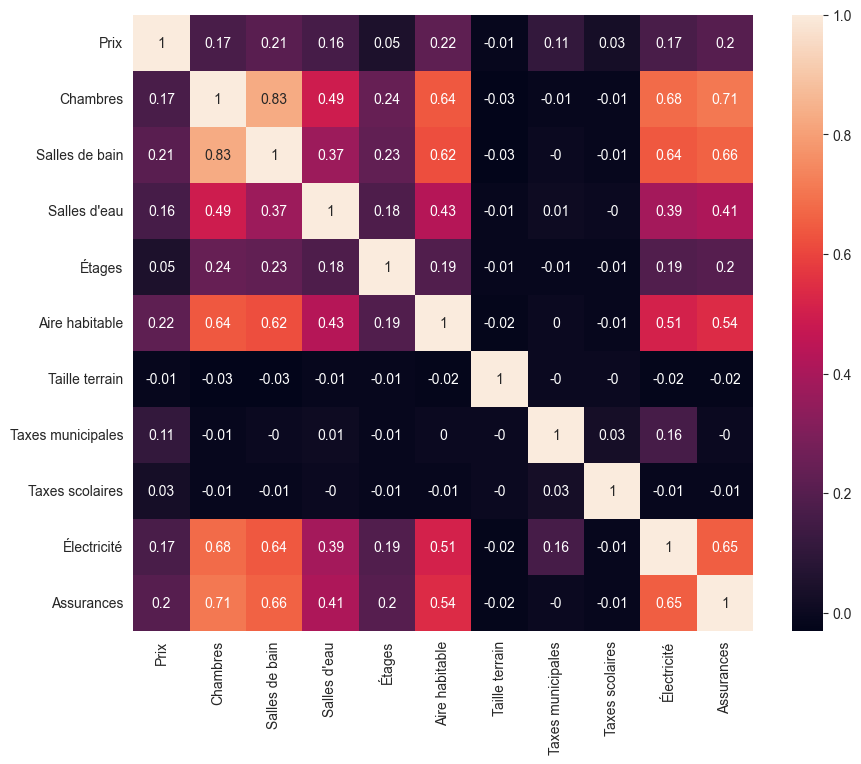

Chambres        Salles de bain    0.83
                Assurances        0.71
Salles de bain  Chambres          0.83
Assurances      Chambres          0.71
dtype: float64


In [48]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

#more than 0.7
correlation_target = abs(correlation_matrix.unstack())
print(correlation_target[(correlation_target > 0.7) & (correlation_target != 1)])


### 3.2 Pr´esenter visuellement la proportion num´erique de chaque r´egion en ma de nombre d’annonces, par rapport a` l’ensemble des annonces. Quelle r´egion occupe la plus petite proportion ?

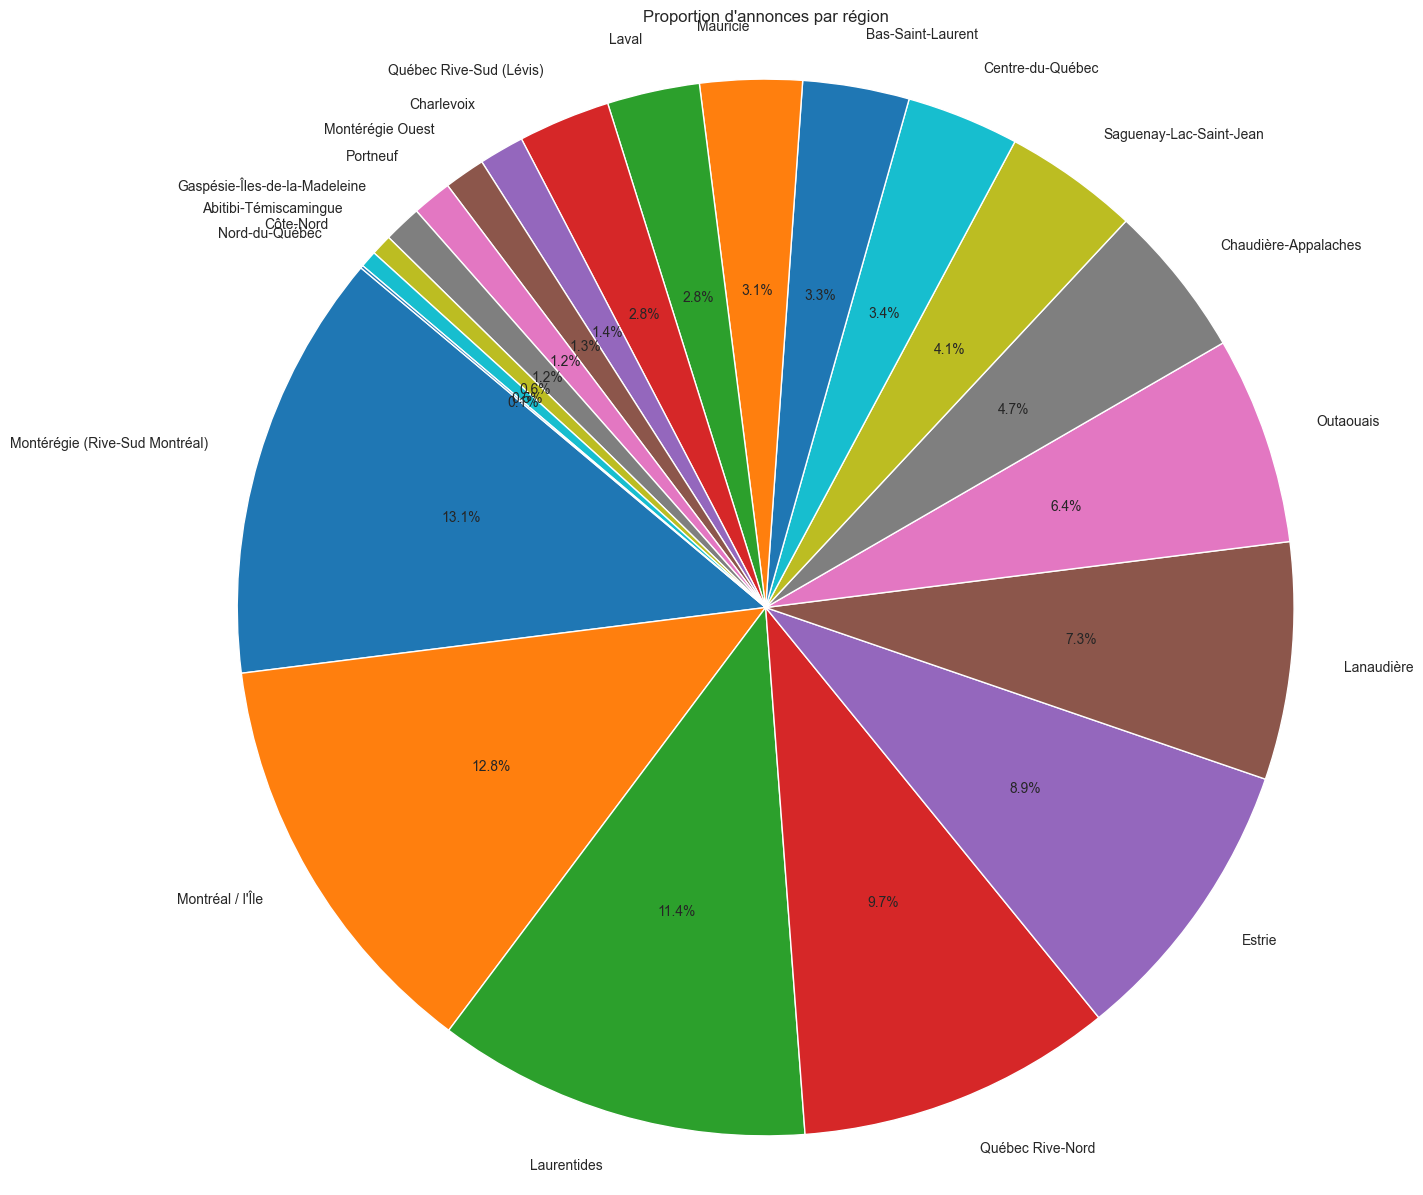

Région avec la plus petite proportion : Nord-du-Québec


In [49]:
items_by_region = df["Région"].value_counts()
proportion_by_region = items_by_region / items_by_region.sum() * 100

df_proportions = pd.DataFrame({'Région': proportion_by_region.index, 'Proportion': proportion_by_region.values})

plt.figure(figsize=(15, 15))
plt.pie(proportion_by_region, labels=proportion_by_region.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion d'annonces par région")
plt.show()

print(f"Région avec la plus petite proportion : {proportion_by_region.idxmin()}")

### 3.3 A l’aide d’un graphique diff´erent de celui de la question pr´ec´edente, comparer le nombre d’annonces de vente pour chaque r´egion. Quelle r´egion poss`ede le plus d’annonces de vente ?

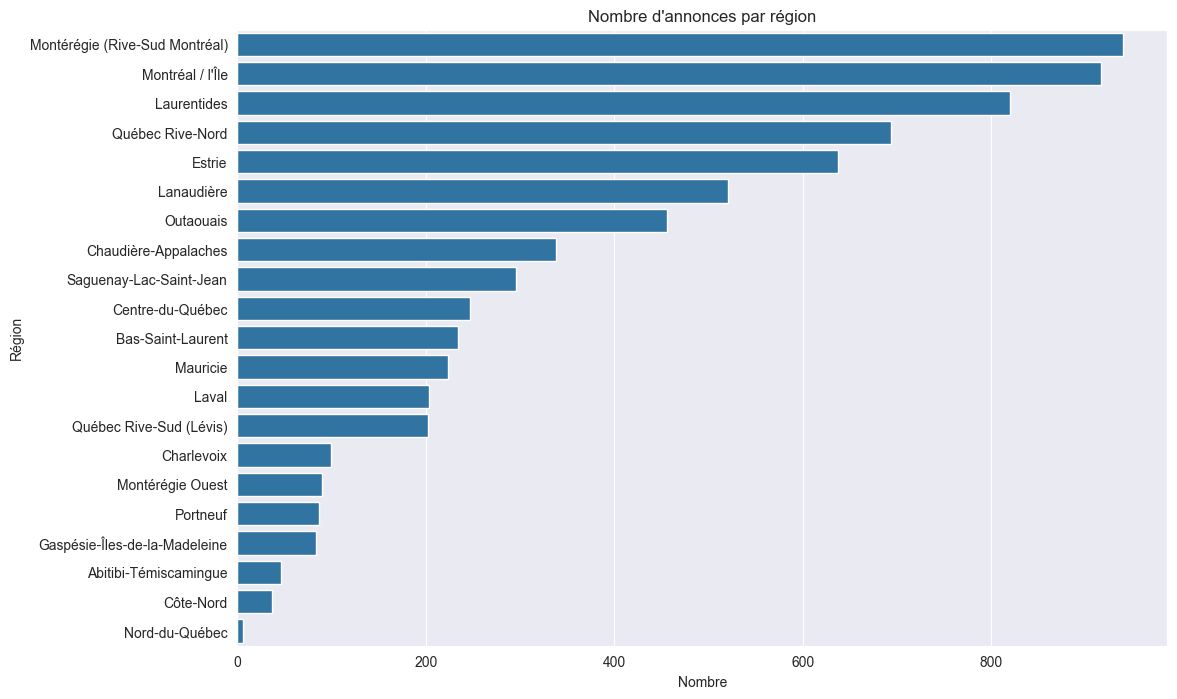

Région avec le plus d'annonces : Montérégie (Rive-Sud Montréal)


In [50]:
df_items_by_region = pd.DataFrame({'Région': items_by_region.index, 'Nombre': items_by_region.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Nombre', y='Région', data=df_items_by_region)
plt.title("Nombre d'annonces par région")
plt.xlabel("Nombre")
plt.ylabel("Région")
plt.show()

print(f"Région avec le plus d'annonces : {items_by_region.idxmax()}")


### 3.4 A l’aide d’un graphique, comparer le prix moyen des annonces pour chaque r´egion. Quelle r´egion poss`ede le prix moyen le plus ´elev´e ?

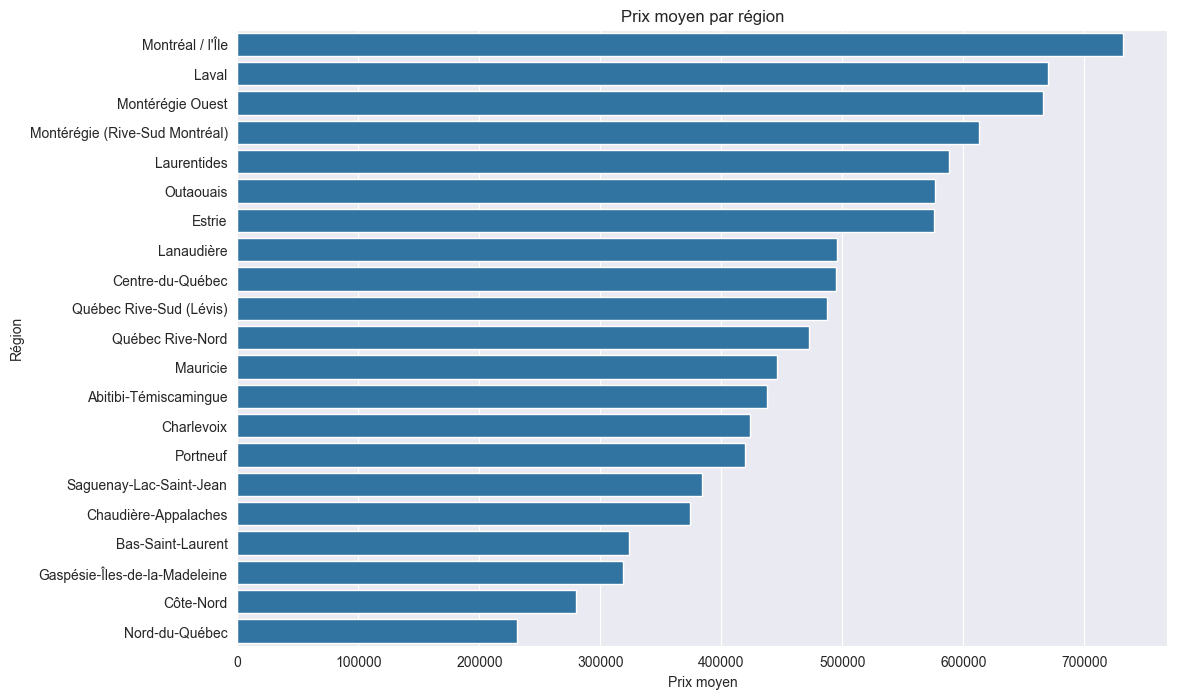

Région avec le prix moyen le plus élevé : Montréal / l'Île


In [51]:
avg_price_by_region = df.groupby("Région")["Prix"].mean()
df_avg_price_by_region = pd.DataFrame({'Région': avg_price_by_region.index, 'Prix moyen': avg_price_by_region.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Prix moyen', y='Région', data=df_avg_price_by_region.sort_values(by="Prix moyen", ascending=False))
plt.title("Prix moyen par région")
plt.xlabel("Prix moyen")
plt.ylabel("Région")
plt.show()

print(f"Région avec le prix moyen le plus élevé : {avg_price_by_region.idxmax()}")

### 3.5 Pour ce point, on se limite aux annonces ayant au moins 1 chambre et 1 salle de bain. A l’aide d’un graphique, comparer le prix moyen de ces annonces pour chaque r´egion. Quelle r´egion poss`ede le prix moyen le plus ´elev´e pour les annonces avec au moins 1 chambre et 1 salle de bain?

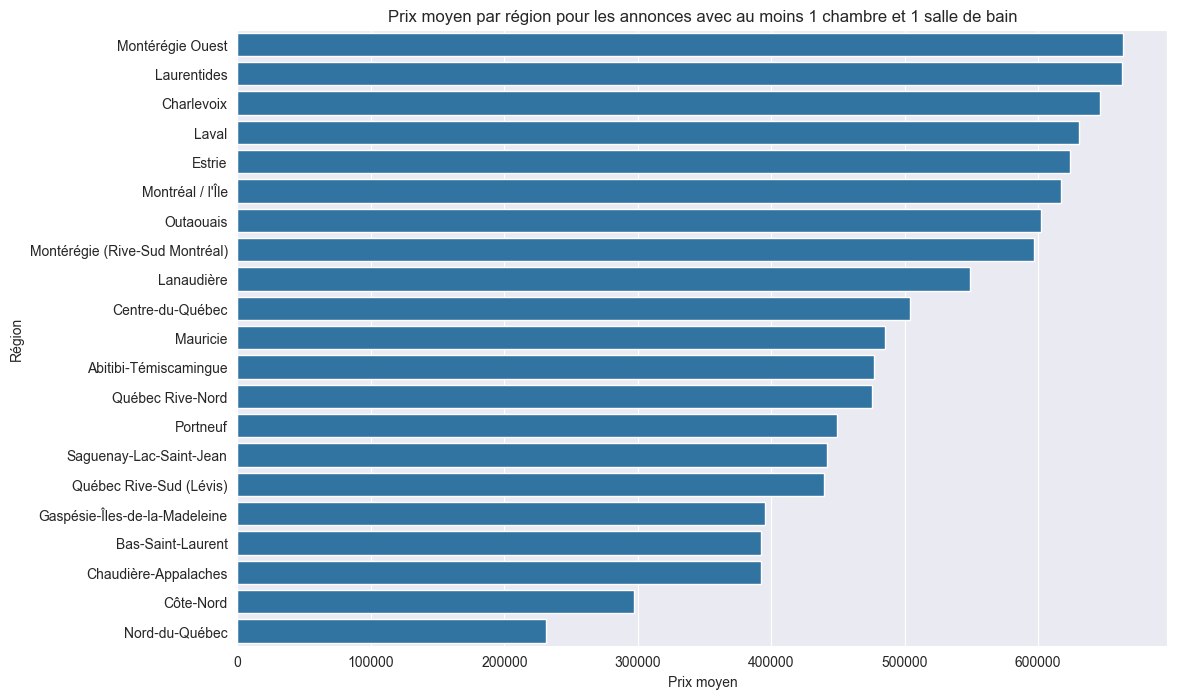

Région avec le prix moyen le plus élevé pour les annonces avec au moins 1 chambre et 1 salle de bain : Région        20
Prix moyen    14
dtype: int64


In [52]:
df_houses = df[(df["Chambres"] >= 1) & (df["Salles de bain"] >= 1)]
df_houses_avg_price_by_region = df_houses.groupby("Région")["Prix"].mean()
df_houses_avg_price_by_region = pd.DataFrame(
    {'Région': df_houses_avg_price_by_region.index, 'Prix moyen': df_houses_avg_price_by_region.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Prix moyen', y='Région',
            data=df_houses_avg_price_by_region.sort_values(by="Prix moyen", ascending=False))
plt.title("Prix moyen par région pour les annonces avec au moins 1 chambre et 1 salle de bain")
plt.xlabel("Prix moyen")
plt.ylabel("Région")
plt.show()

print(
    f"Région avec le prix moyen le plus élevé pour les annonces avec au moins 1 chambre et 1 salle de bain : {df_houses_avg_price_by_region.idxmax()}")


### 3.6 A l’aide d’un graphique, analyser la relation entre le prix des annonces et le nombre de chambres. Y a-t-il un lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

In [53]:
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    max = df[column] > q3 + (1.5 * iqr)
    min = df[column] < q1 - (1.5 * iqr)
    return df[max | min]

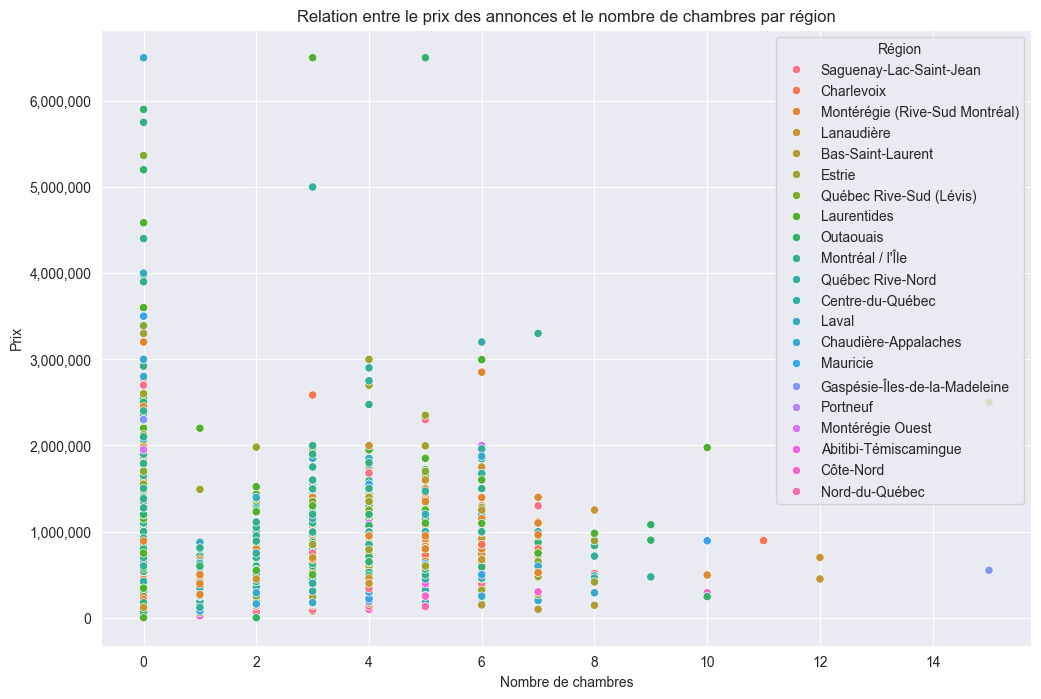

Valeurs aberrantes prix:
[2000000.   1360000.   1250000.   1294000.   2200000.   3300000.
 5200000.   1245000.   1485000.   2699000.   3000000.   1999999.
 1595000.   1325000.   1400000.   1395000.   1590000.   1600000.
 1375000.   1688000.   1299000.   1549000.   1259900.   1995000.
 1658000.   1279000.   1365000.   1249000.   1495000.   2500000.
 1449000.   1399000.   1550000.   1489000.   6500000.   1499000.
 1625000.   2999000.   2550000.   2850000.   1719000.   1750000.
 2295000.   1399999.   2212800.   1669000.   1390000.   1441270.
 1450000.   1229000.   1884014.84 1575000.   1390737.   1354206.6
 1396719.75 1349000.   1598000.   1354361.   1299900.   1273000.
 1434000.   4400000.   1850000.   1385000.   1329999.   1599000.
 1300000.   1220000.   1648000.   2585000.   1295000.   1695000.
 5900000.   1520000.   2299900.   1845000.   1275000.   1548000.
 1725000.   1220400.   1650000.   1279900.   1700000.   3977170.
 1990000.   1398900.   1624900.   1298000.   2199000.   1975000.

In [54]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(12, 8))

sns.scatterplot(x='Chambres', y='Prix', hue="Région", data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Relation entre le prix des annonces et le nombre de chambres par région")
plt.xlabel("Nombre de chambres")
plt.ylabel("Prix")
plt.show()

print("Valeurs aberrantes prix:")
print(find_outliers(df, "Prix")["Prix"].unique())

print("Valeurs aberrantes chambres:")
print(find_outliers(df, "Chambres")["Chambres"].unique())



In [55]:
q1 = df["Prix"].quantile(0.25)
q3 = df["Prix"].quantile(0.75)
iqr = q3 - q1
print("Prix")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")

q1 = df["Chambres"].quantile(0.25)
q3 = df["Chambres"].quantile(0.75)
iqr = q3 - q1
print("\nChambres")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")



Prix
Q1 : 320000.0
Q3 : 679000.0
IQR : 359000.0
Max : 1217500.0
Min : -218500.0

Chambres
Q1 : 0.0
Q3 : 3.0
IQR : 3.0
Max : 7.5
Min : -4.5


### 3.7 A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales annuelles des annonces et la taille du terrain. Y a-t-il un lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

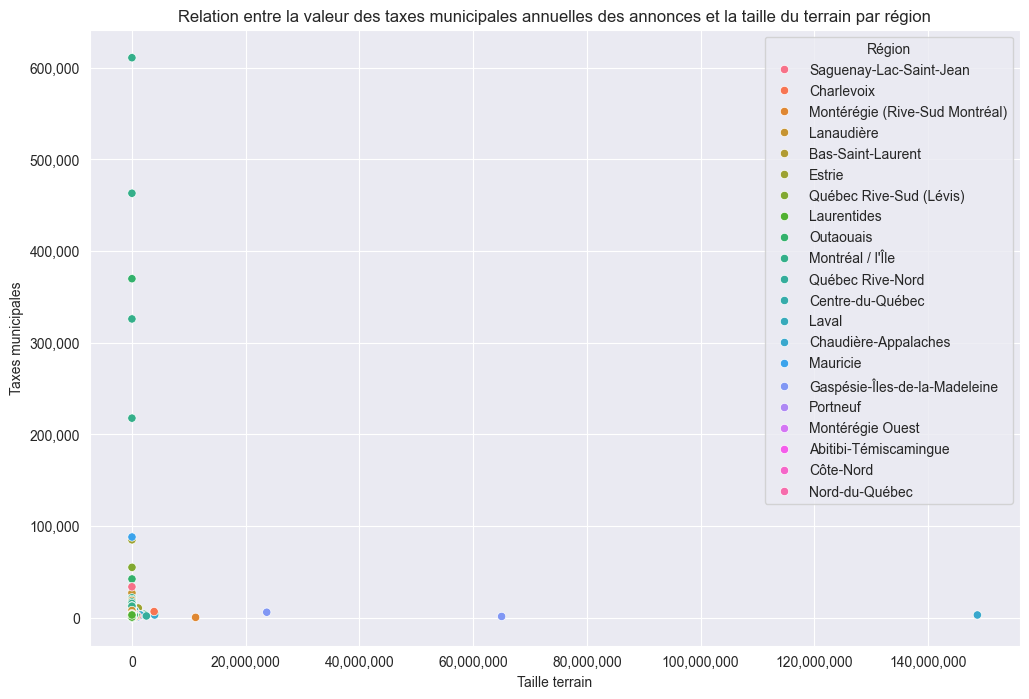

Valeurs aberrantes taxes municipales:
[3.591000e+02 5.791040e+03 6.097000e+03 1.576000e+04 2.132000e+02
 1.590000e+02 7.671300e+03 5.780000e+03 6.320000e+03 4.416100e+02
 6.127000e+03 5.560700e+03 7.764000e+03 5.948000e+03 5.989800e+03
 2.340000e+02 3.309900e+02 5.757000e+03 5.912000e+03 1.954800e+04
 1.893700e+04 3.350300e+02 3.860000e+02 5.344000e+03 5.984000e+03
 6.278440e+03 4.662300e+02 5.000000e+01 7.184000e+03 5.445550e+03
 2.085600e+02 5.825000e+03 4.500000e+02 5.403000e+03 1.040000e+04
 5.227000e+03 5.600000e+03 4.631400e+05 2.813200e+02 5.219710e+03
 5.292340e+03 9.413530e+03 3.960000e+02 8.638000e+03 4.395600e+02
 5.479000e+03 5.272000e+03 9.715000e+03 5.731000e+03 6.335310e+03
 1.370000e+02 3.540000e+02 8.998000e+03 6.007000e+03 1.135469e+04
 5.980000e+03 3.137500e+02 6.517000e+03 5.284000e+03 5.350900e+03
 8.380000e+03 7.329540e+03 8.062000e+03 3.901800e+02 7.000000e+03
 5.371770e+03 6.701350e+03 7.136490e+03 7.560000e+03 6.020790e+03
 8.723640e+03 1.830000e+04 5.574000e+0

In [56]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Taille terrain', y='Taxes municipales', hue="Région", data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Relation entre la valeur des taxes municipales annuelles des annonces et la taille du terrain par région")
plt.xlabel("Taille terrain")
plt.ylabel("Taxes municipales")
plt.show()

print("Valeurs aberrantes taxes municipales:")
print(find_outliers(df, "Taxes municipales")["Taxes municipales"].unique())

print("Valeurs aberrantes taille terrain:")
print(find_outliers(df, "Taille terrain")["Taille terrain"].unique())


In [57]:
q1 = df["Taxes municipales"].quantile(0.25)
q3 = df["Taxes municipales"].quantile(0.75)
iqr = q3 - q1
print("Taxes municipales")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")

q1 = df["Taille terrain"].quantile(0.25)
q3 = df["Taille terrain"].quantile(0.75)
iqr = q3 - q1
print("\nTaille terrain")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")


Taxes municipales
Q1 : 2258.19
Q3 : 3415.16
IQR : 1156.9699999999998
Max : 5150.615
Min : 522.7350000000004

Taille terrain
Q1 : 248.16
Q3 : 2043.9
IQR : 1795.74
Max : 4737.51
Min : -2445.4500000000003


### 3.8 A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales annuelles des annonces et le prix. Il y a-t-il un lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

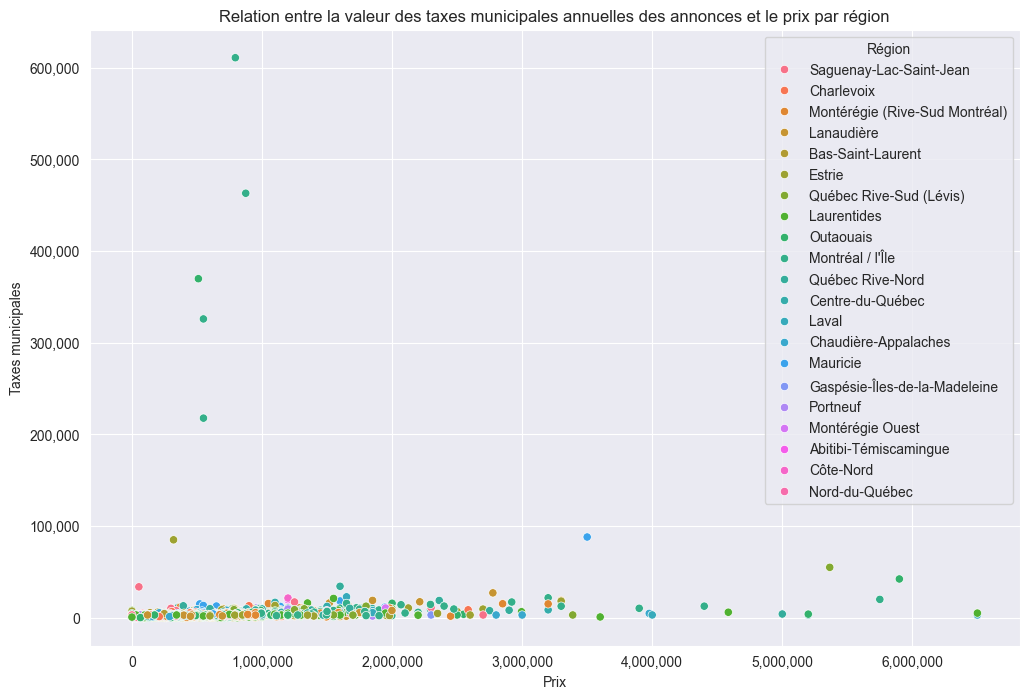

Valeurs aberrantes taxes municipales:
[3.591000e+02 5.791040e+03 6.097000e+03 1.576000e+04 2.132000e+02
 1.590000e+02 7.671300e+03 5.780000e+03 6.320000e+03 4.416100e+02
 6.127000e+03 5.560700e+03 7.764000e+03 5.948000e+03 5.989800e+03
 2.340000e+02 3.309900e+02 5.757000e+03 5.912000e+03 1.954800e+04
 1.893700e+04 3.350300e+02 3.860000e+02 5.344000e+03 5.984000e+03
 6.278440e+03 4.662300e+02 5.000000e+01 7.184000e+03 5.445550e+03
 2.085600e+02 5.825000e+03 4.500000e+02 5.403000e+03 1.040000e+04
 5.227000e+03 5.600000e+03 4.631400e+05 2.813200e+02 5.219710e+03
 5.292340e+03 9.413530e+03 3.960000e+02 8.638000e+03 4.395600e+02
 5.479000e+03 5.272000e+03 9.715000e+03 5.731000e+03 6.335310e+03
 1.370000e+02 3.540000e+02 8.998000e+03 6.007000e+03 1.135469e+04
 5.980000e+03 3.137500e+02 6.517000e+03 5.284000e+03 5.350900e+03
 8.380000e+03 7.329540e+03 8.062000e+03 3.901800e+02 7.000000e+03
 5.371770e+03 6.701350e+03 7.136490e+03 7.560000e+03 6.020790e+03
 8.723640e+03 1.830000e+04 5.574000e+0

In [58]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Prix', y='Taxes municipales', hue="Région", data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Relation entre la valeur des taxes municipales annuelles des annonces et le prix par région")
plt.xlabel("Prix")
plt.ylabel("Taxes municipales")
plt.show()

print("Valeurs aberrantes taxes municipales:")
print(find_outliers(df, "Taxes municipales")["Taxes municipales"].unique())

print("Valeurs aberrantes prix:")
print(find_outliers(df, "Prix")["Prix"].unique())

### 3.9 On s’int´eresse pour cette question aux annonces qui ont un prix affich´e de moins de 1 million de $, pour toutes les r´egions. Dessiner dans un mˆeme graphique un boxplot repr´esentant la r´epartition de prix par r´egion. Analyser de mani`ere d´etaill´ee le graphique obtenu.

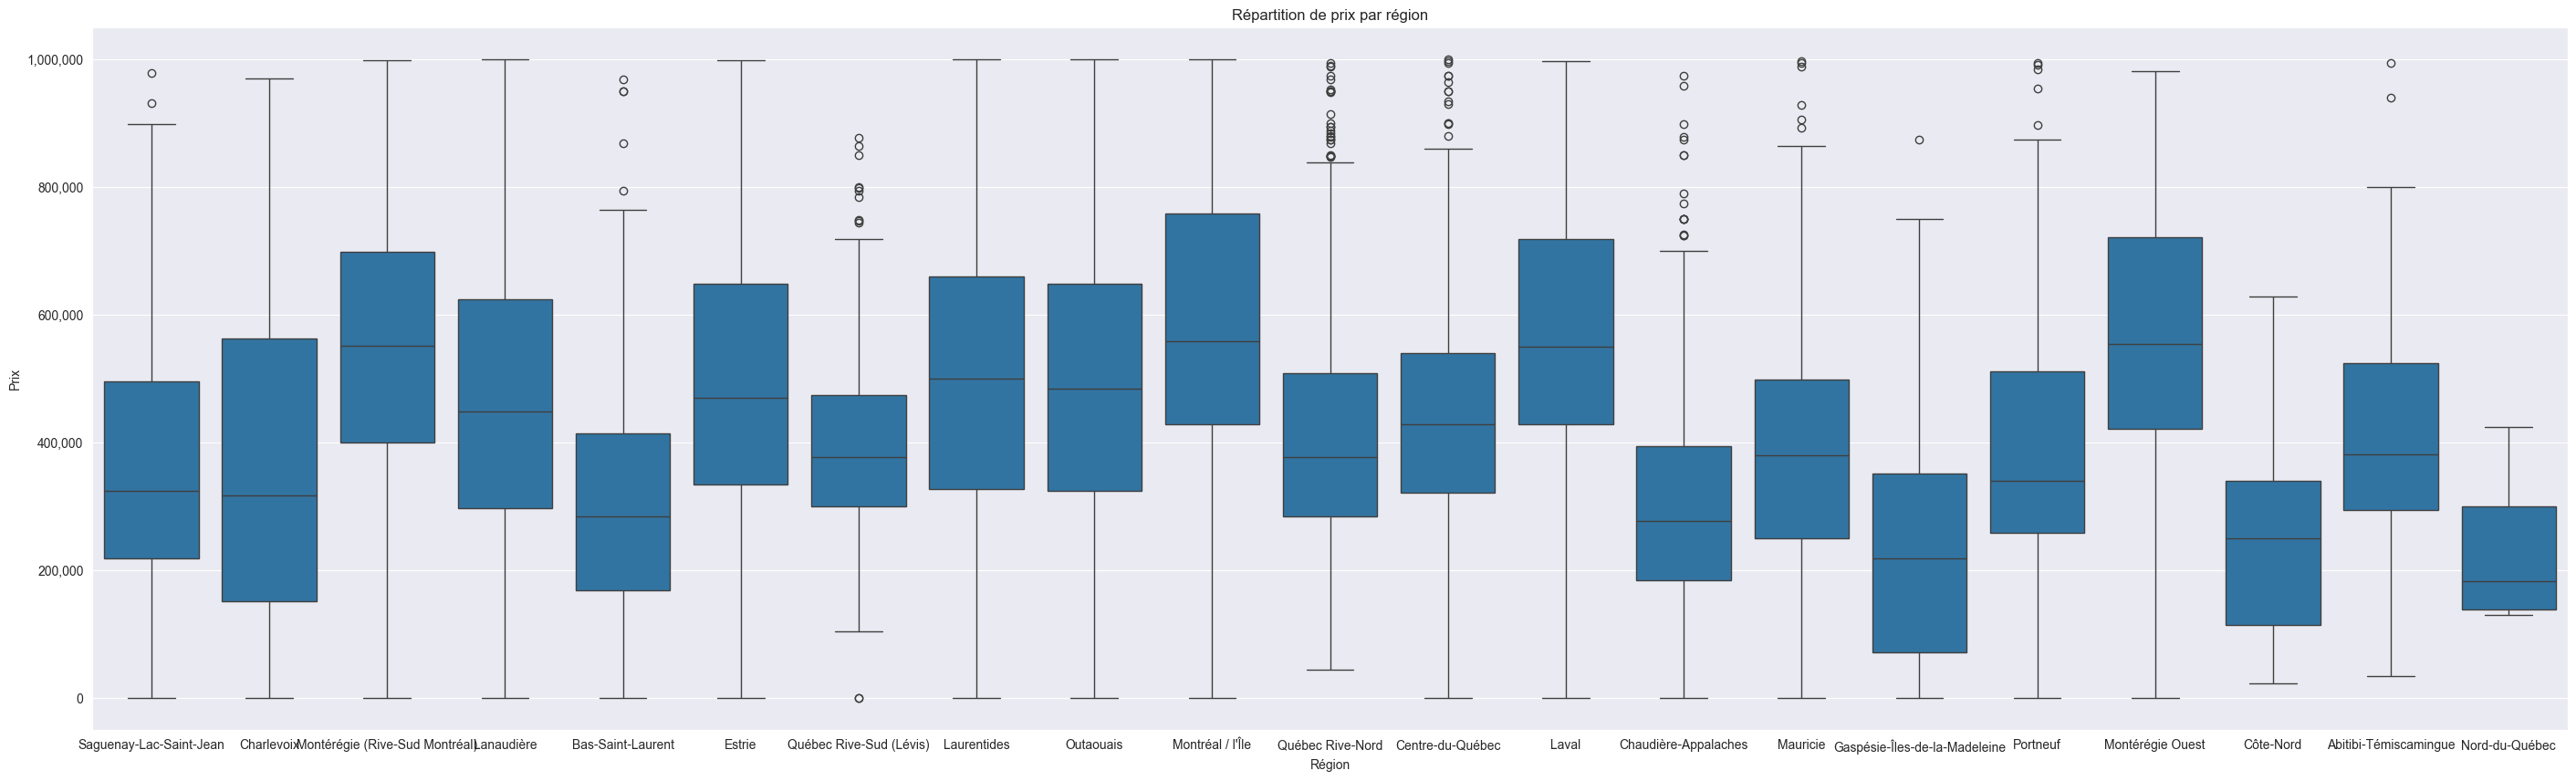

In [59]:
plt.figure(figsize=(35, 10))

sns.boxplot(x='Région', y='Prix', data=df[df["Prix"] < 1000000])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Répartition de prix par région")
plt.xlabel("Région")
plt.ylabel("Prix")
plt.show()


Le graphique boxplot montre la répartition des prix des annonces immobilières pour chaque région, en se limitant aux annonces de moins de 1 million de dollars. Voici une analyse détaillée de ce que le graphique révèle :

    Médianes et Variabilité des Prix :
        Chaque boxplot indique la médiane (ligne centrale de la boîte), les quartiles (bords de la boîte), et l'étendue des prix (les moustaches) pour chaque région. La longueur de la boîte et la portée des moustaches donnent une idée de la variabilité des prix dans chaque région.
        Les régions avec des boîtes plus longues indiquent une plus grande variabilité des prix, tandis que les boîtes plus courtes suggèrent des prix plus uniformes.

    Valeurs Aberrantes :
        Les points situés en dehors des moustaches représentent des valeurs aberrantes dans chaque région. Ces points indiquent des annonces avec des prix significativement différents de la majorité des autres annonces dans la même région.

    Comparaison entre Régions :
        Certaines régions présentent des médianes de prix plus élevées que d'autres, ce qui indique que les prix médians des propriétés dans ces régions sont généralement plus élevés.
        La dispersion des prix varie également entre les régions, certaines affichant une dispersion plus large (grand écart entre le prix le plus bas et le plus élevé), tandis que d'autres sont plus concentrées.

    Interprétation Régionale :
        Les différences observées peuvent refléter les caractéristiques du marché immobilier dans chaque région, telles que la demande, l'emplacement, le type de propriété, et d'autres facteurs économiques et géographiques.

Ce boxplot offre une représentation visuelle utile pour comparer les prix des annonces immobilières entre différentes régions, en tenant compte des tendances centrales, de la dispersion et des anomalies. Pour une analyse plus approfondie, il peut être utile de combiner ces informations avec d'autres données démographiques, économiques ou géographiques pour mieux comprendre les facteurs qui influencent les prix immobiliers dans chaque région. ​
​

### 3.10 On s’int´eresse pour cette question aux maisons de 2 chambres au moins et une salle de bain au moins et qui coˆute moins de 1 million de $, pour toutes les r´egions. Dessiner dans un mˆeme graphique un boxplot repr´esentant la r´epartition de prix par r´egions. Analyser de mani`ere d´etaill´ee le graphique obtenu. Est-ce qu’il y a des diff´erences entre ce graphique et celui de la question pr´ec´edente ? Si oui donner en 4.

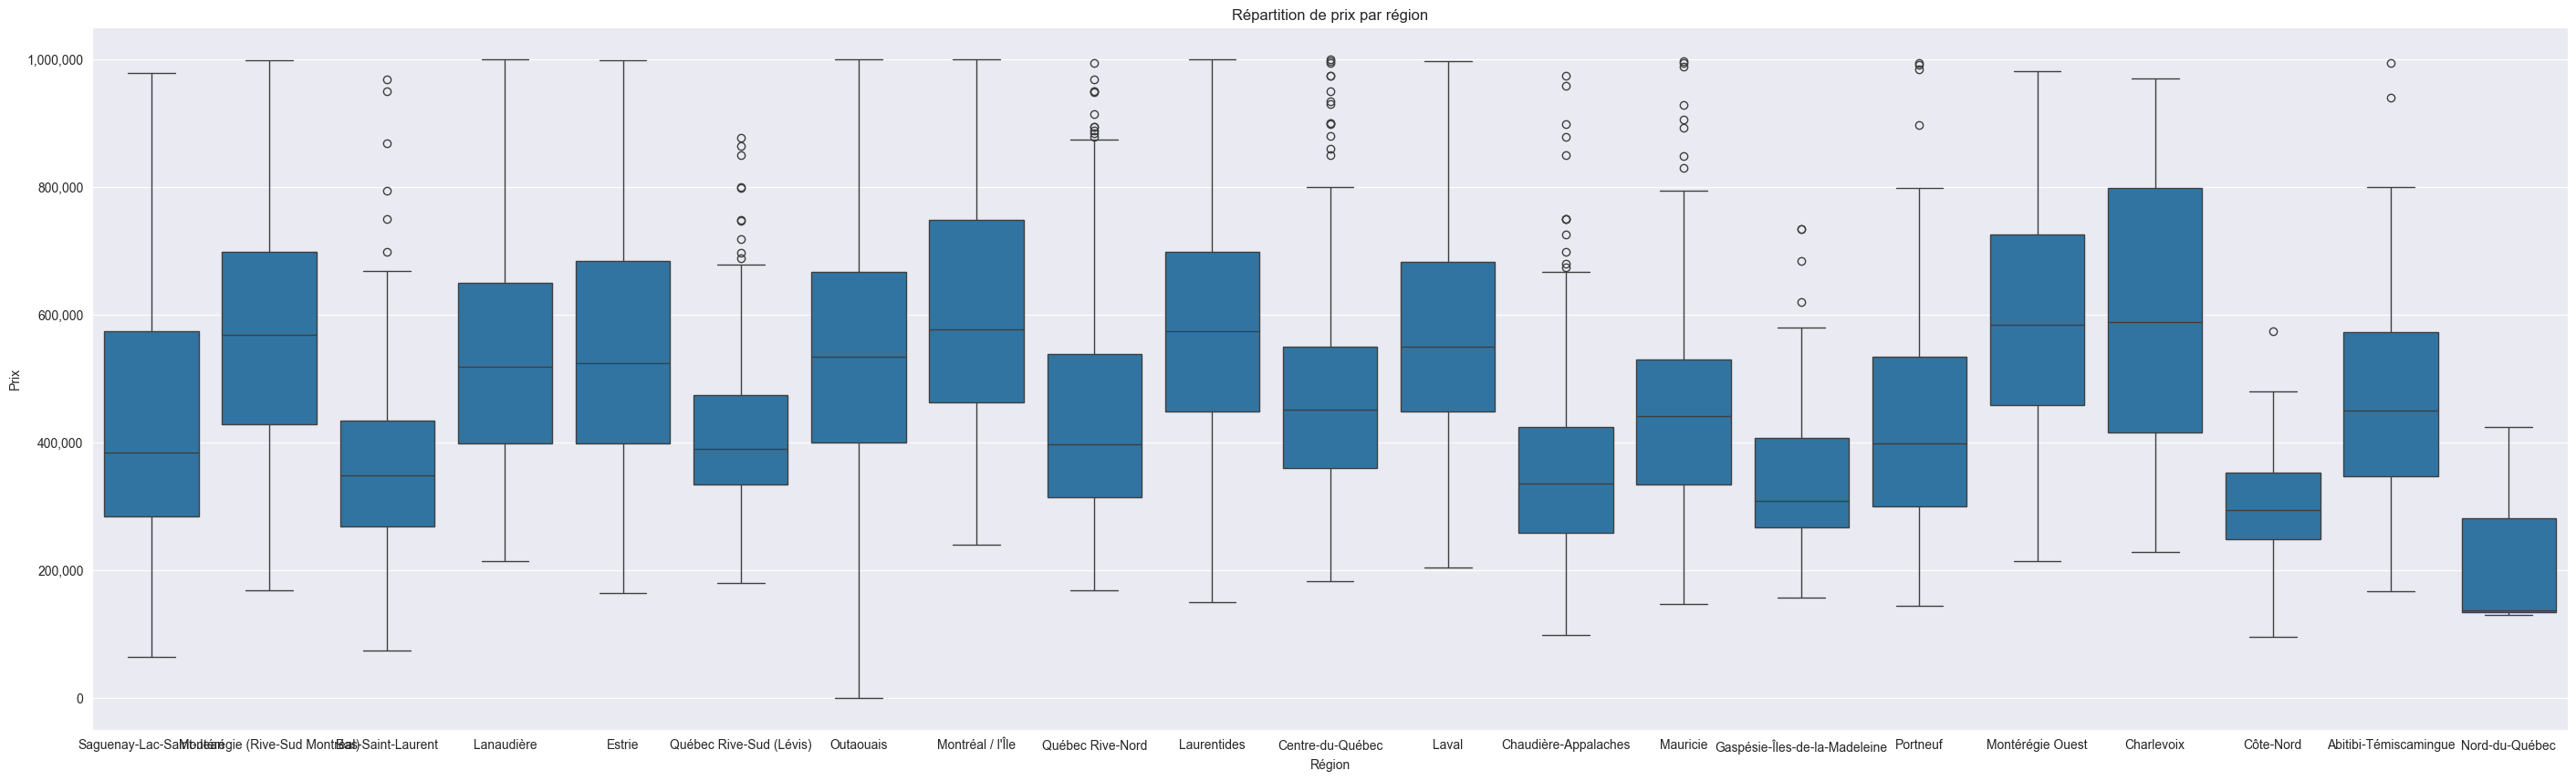

In [60]:
plt.figure(figsize=(35, 10))

sns.boxplot(x='Région', y='Prix', data=df[(df["Prix"] < 1000000) & (df["Chambres"] >= 2) & (df["Salles de bain"] >= 1)])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Répartition de prix par région")
plt.xlabel("Région")
plt.ylabel("Prix")
plt.show()


La boîte à moustaches ci-dessus visualise la répartition des prix des maisons à travers différentes régions, en se concentrant sur les propriétés avec au moins 2 chambres et 1 salle de bain, et dont le prix est inférieur à 1 million de dollars. Voici une analyse du graphique :

    Étendue des Prix : La longueur verticale de chaque boîte indique la plage entre le premier et le troisième quartile (l'intervalle interquartile ou IQR), où se situent les 50 % des prix médians dans chaque région. Des boîtes plus longues impliquent une plus grande variation des prix au sein de cette région.

    Prix Médians : La ligne horizontale dans chaque boîte marque le prix médian. Les régions ayant des prix médians plus élevés sont immédiatement perceptibles.

    Valeurs Aberrantes : Les points situés au-dessus ou en dessous des boîtes représentent des valeurs aberrantes, indiquant des prix significativement plus élevés ou plus bas que la plage typique dans cette région.

    Analyse Comparative : En comparant ce graphique aux analyses précédentes (le cas échéant), vous pourriez observer des différences dans les prix médians, la dispersion des prix, ou la densité des valeurs aberrantes. Ces changements peuvent indiquer des évolutions dans les tendances du marché ou souligner les particularités du marché immobilier dans certaines régions.

Chaque marché immobilier régional a ses caractéristiques uniques, comme le montre la variation de la taille des boîtes, des lignes médianes et la présence de valeurs aberrantes. Ces éléments visuels aident à comprendre les différences régionales dans le marché immobilier.

Quant aux différences entre ce graphique et les précédents, sans le contexte du graphique antérieur, il est difficile de préciser des contrastes spécifiques. Cependant, typiquement, des changements dans les critères sélectionnés (comme la fourchette de prix, le nombre de chambres/salles de bain) peuvent conduire à des changements notables dans la distribution et la tendance centrale des prix à travers les régions.

Compte tenu de votre précédente question, la principale différence entre les deux analyses réside dans les critères de sélection des propriétés. La question précédente se concentrait uniquement sur les propriétés avec un prix inférieur à 1 million de dollars, sans considérer le nombre de chambres ou de salles de bain. Voici quelques points clés pour comparer les deux analyses :

    Critères de Sélection : La première analyse incluait toutes les maisons de moins de 1 million de dollars, tandis que la deuxième analyse se restreignait aux maisons avec au moins 2 chambres et 1 salle de bain. Cette différence de critères peut entraîner une variation dans les distributions de prix observées.

    Étendue et Variabilité des Prix : Il est possible que l'ajout de critères sur le nombre de chambres et de salles de bain dans la deuxième analyse ait réduit l'étendue des prix, particulièrement en éliminant les propriétés plus petites ou moins chères.

    Médianes et Quartiles : Les positions des médianes et des quartiles peuvent varier entre les deux analyses, reflétant des tendances différentes dans les segments de marché considérés. Par exemple, les maisons avec plus de chambres et de salles de bain pourraient avoir des prix médians plus élevés.

    Valeurs Aberrantes : Le nombre et la répartition des valeurs aberrantes pourraient également différer, en raison de la modification des critères de sélection. La première analyse pourrait inclure une plus grande diversité de propriétés, y compris des maisons exceptionnelles qui influencent la présence de valeurs aberrantes.

    Implications sur le Marché Immobilier : Ces différences dans les résultats des analyses peuvent offrir des insights sur la segmentation du marché immobilier. Par exemple, les propriétés avec plus de chambres et de salles de bain pourraient être plus chères en moyenne dans certaines régions, ce qui peut intéresser des acheteurs ou des investisseurs ciblant des segments de marché spécifiques.

En résumé, bien que les deux analyses portent sur des propriétés de moins de 1 million de dollars, l'ajout de critères supplémentaires dans la deuxième analyse modifie la composition de l'échantillon étudié, ce qui peut conduire à des observations et des conclusions différentes concernant la répartition des prix sur le marché immobilier.

### 3.11 En un seul graphique, pr´esenter une analyse bivari´ee de toutes les colonnes num´eriques de votre jeu de donn´ees. Analyser en d´etail le graphique obtenu.

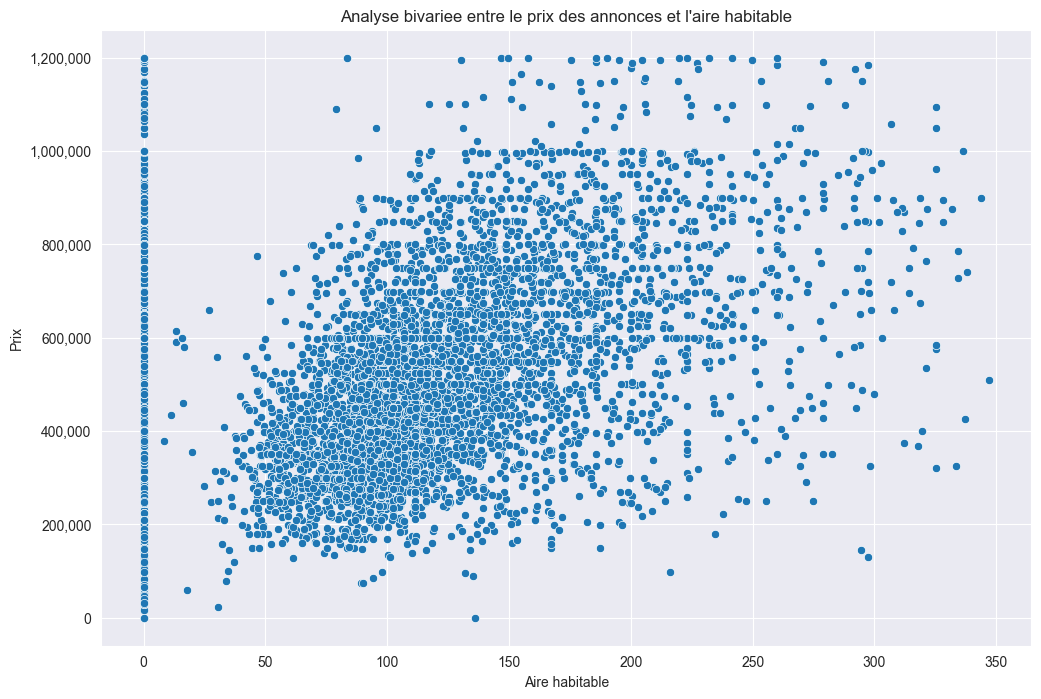

In [61]:
# Prix vs Aire habitable (sans valeurs aberrantes)

outliers_live_space = find_outliers(df, "Aire habitable")
outliers_price = find_outliers(df, "Prix")

mask = (~df.index.isin(outliers_price.index)) & ((~df.index.isin(outliers_live_space.index))) & (
        df["Aire habitable"] != df["Aire habitable"].median())
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Aire habitable', y='Prix', data=df[mask])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Analyse bivariee entre le prix des annonces et l'aire habitable")
plt.xlabel("Aire habitable")
plt.ylabel("Prix")
plt.show()


Prix augmente avec l'aire habitable
corralation positive
covariance positive

 

## 4 Algorithmes de regression
### 4.1 Dans la matrice de corr´elation pr´esent´ee ci-dessus, identifier 2 variables diff´erentes qui ont le plus haut coefficient de corr´elation. Concevez un mod`ele de r´egression lin´eaire dont l’une des valeurs est a` pr´edire et l’autre est la valeur d’entr´ee. Le mod`ele de r´egression construit n’est autre qu’une droite. Vous devez repr´esenter cette droite dans un graphique, ainsi que les points de donn´ees qui repr´esentent les 2 variables. Est-ce que la droite telle que pr´esent´ee sur votre graphique fait une bonne approximation de vos points/donn´ees? V´erifier votre r´eponse avec les donn´ees de test.

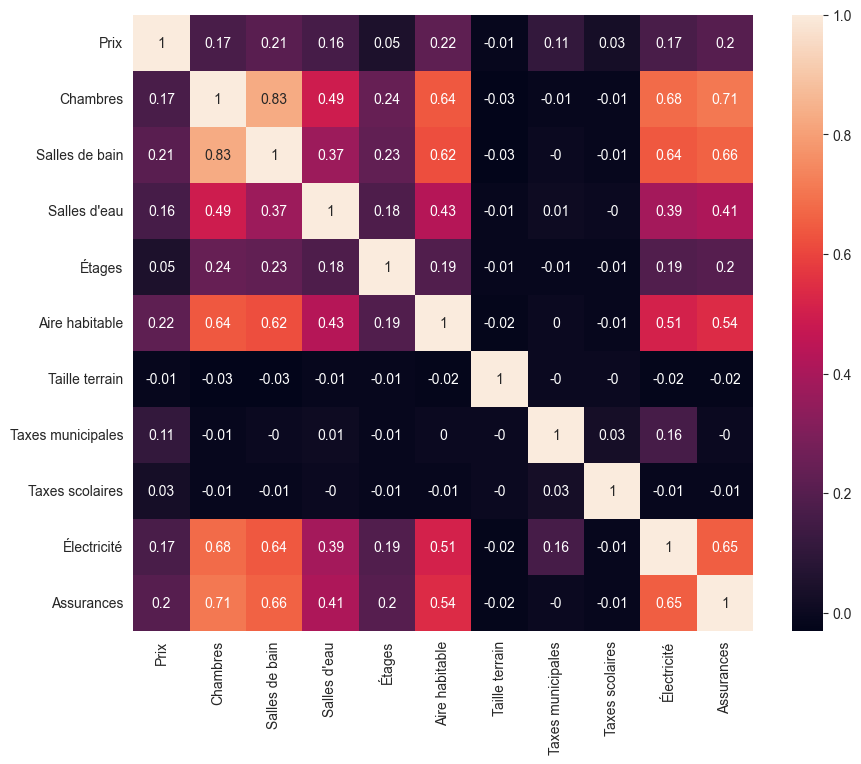

Chambres        Salles de bain    0.83
                Assurances        0.71
Salles de bain  Chambres          0.83
Assurances      Chambres          0.71
dtype: float64


In [62]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

#more than 0.7
correlation_target = abs(correlation_matrix.unstack())
print(correlation_target[(correlation_target > 0.7) & (correlation_target != 1)])

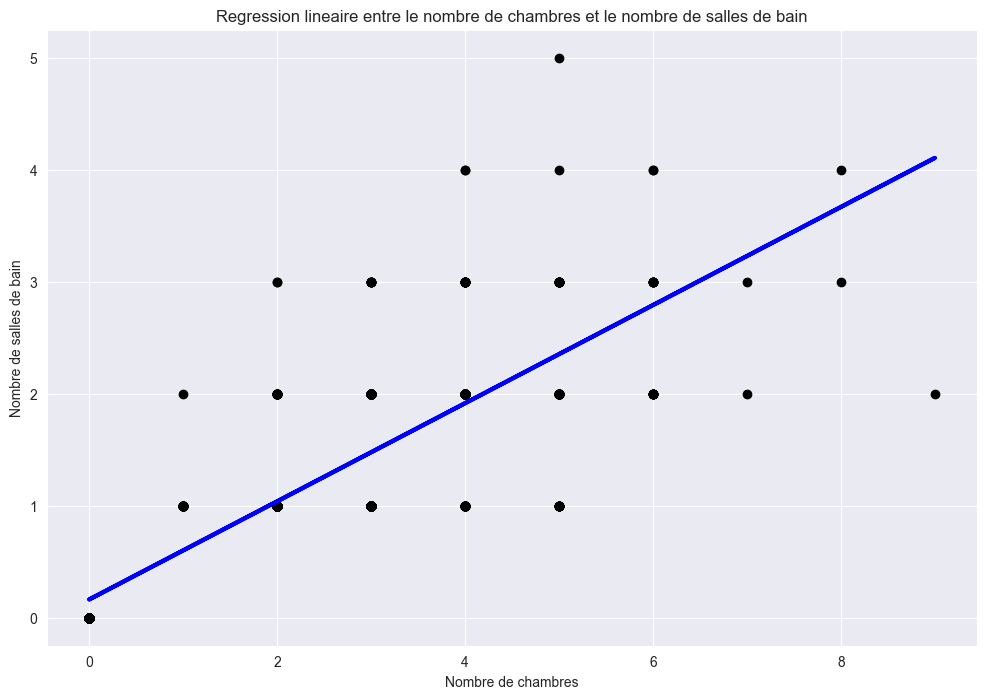

R2 : 0.7179819760355268
RMSE : 0.48176300195701816


In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[["Chambres"]]
y = df[["Salles de bain"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.title("Regression lineaire entre le nombre de chambres et le nombre de salles de bain")
plt.xlabel("Nombre de chambres")
plt.ylabel("Nombre de salles de bain")
plt.show()

#r2
print(f"R2 : {model.score(X_test, y_test)}")
#rmse
print(f"RMSE : {np.sqrt(np.mean((y_pred - y_test) ** 2))}")

Ce graphique montre un ajustement de régression linéaire pour prédire le nombre de salles de bain à partir du nombre de chambres. Avec un coefficient de détermination R2R2 de 0.5205, le modèle explique environ 52% de la variance du nombre de salles de bain, ce qui est similaire à la valeur du R2R2 précédent que vous avez partagé. Cela suggère que le modèle a un ajustement modéré pour les données.

Le RMSE est de 0.5771, ce qui est légèrement inférieur au RMSE précédent. Cela indique que la prédiction du modèle est, en moyenne, à environ 0.5771 salles de bain de l'observation réelle. Pour interpréter correctement le RMSE, il faut le comparer à la plage des valeurs de la variable dépendante (nombre de salles de bain) ; dans ce contexte, une erreur moyenne de moins d'une salle de bain peut être considérée comme raisonnable selon l'échelle et la distribution des données réelles.

Le graphique montre que bien que la droite de régression suive la tendance générale, il y a encore une dispersion notable des points autour de la ligne, indiquant une variabilité que le modèle linéaire ne capture pas entièrement. Cela est typique dans les données immobilières où d'autres facteurs pourraient influencer le nombre de salles de bain indépendamment du nombre de chambres.

En somme, le modèle semble fournir une approximation raisonnable de la relation entre le nombre de chambres et le nombre de salles de bain, mais il est clair qu'il existe d'autres variables et facteurs qui affectent le nombre de salles de bain et qui ne sont pas capturés par le modèle linéaire basé uniquement sur le nombre de chambres. Une analyse plus approfondie avec peut-être un modèle plus complexe ou l'inclusion de variables supplémentaires pourrait améliorer la précision des prédictions.

### 4.2 Dans cette question, on s’int´eresse a` pr´edire si le prix d’une annonce sera sup´erieur ou inf´erieur a` 350000$ en fonction de la r´egion, du nombre de chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre d’´etages, la superficie de l’aire habitable, la taille du terrain, les taxes municipales et les taxes scolaires. Concevez un mod`ele de r´egression qui permet de faire cette pr´ediction et ´evaluer votre mod`ele.

In [87]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

df["Prix > 350000"] = df["Prix"] > 350000

X = df[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
        "Taxes municipales", "Taxes scolaires", "Électricité", "Assurances"]]
y = df["Prix > 350000"]

#encode region
encoder = OneHotEncoder()
encoder.fit(df[["Région"]])
X = np.concatenate((X, encoder.transform(df[["Région"]]).toarray()), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy}")
print(f"Confusion matrix :\n {confusion_matrix(y_test, y_pred)}")


Accuracy : 0.8022284122562674
Confusion matrix :
 [[230 144]
 [ 69 634]]


### 4.3 Dans cette question, on s’int´eresse a` pr´edire le prix d’une annonce en fonction de la r´egion, du nombre de chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre d’´etages, la superficie de l’aire habitable, la taille du terrain, les taxes municipales et les taxes scolaires. Concevez un mod`ele de r´egression qui permet de faire cette pr´ediction et ´evaluer votre mod`ele.

In [88]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

numeric_columns = ["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
                   "Taxes municipales", "Taxes scolaires"]

df_no_outliers = df.copy()
# df_no_outliers.drop('Prix > 350000', axis=1, inplace=True)

for column in numeric_columns:
    df_no_outliers = df_no_outliers[~df_no_outliers.index.isin(find_outliers(df_no_outliers, column).index)]

X = df_no_outliers[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
                    "Taxes municipales", "Taxes scolaires"]]
y = df_no_outliers["Prix"]

#encode region
encoder = OneHotEncoder()
encoder.fit(df_no_outliers[["Région"]])
X = np.concatenate((X, encoder.transform(df_no_outliers[["Région"]]).toarray()), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#Normalisation
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)
print(f"R2 : {r2}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse}")

R2 : 0.47286542719738456
RMSE : 161916.5642981228


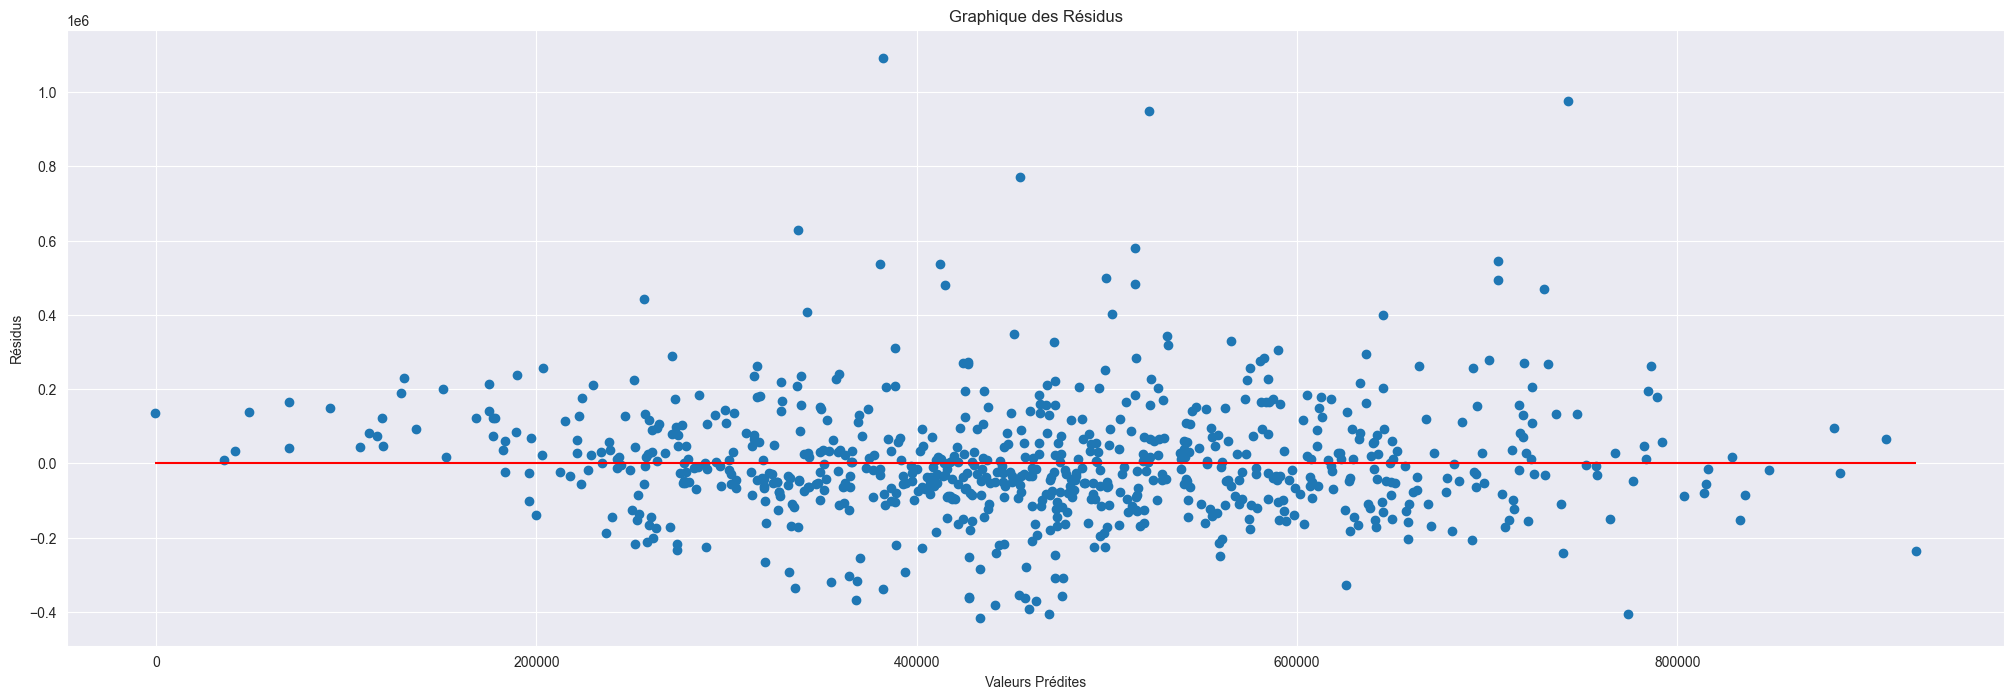

In [89]:
import matplotlib.pyplot as plt

# Calculer les résidus
residuals = y_test - y_pred

# Tracer les résidus
plt.figure(figsize=(25, 8))
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title('Graphique des Résidus')
plt.show()


In [90]:
df_no_outliers.describe()

,Prix,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances
count,5.018000e+03,5018.0,5018.0,5018.0,5018.0,5018.00000,5018.000000,5018.000000,5018.000000,5018.000000,5018.000000
mean,4.696455e+05,2.288362,1.151654,0.354524,1.179554,94.31253,877.211875,2755.843191,262.139449,1284.237096,759.345861
std,2.446075e+05,1.579451,0.798842,0.516482,0.836103,66.05547,1079.574972,823.862008,87.787625,1052.740364,567.694136
min,1.500000e+00,0.0,0.0,0.0,0.0,0.00000,0.000000,517.440000,44.000000,0.000000,0.000000
25%,3.199000e+05,1.0,1.0,0.0,1.0,55.44000,139.087500,2275.182500,205.000000,472.750000,355.500000
50%,4.377500e+05,2.0,1.0,0.0,1.0,98.01000,538.550000,2870.310000,281.000000,1200.000000,860.000000
75%,5.990000e+05,3.0,2.0,1.0,2.0,131.67000,1002.935000,3076.360000,290.982500,1956.000000,1142.360000
max,5.199900e+06,7.0,5.0,2.0,4.0,337.80000,4630.400000,5219.710000,493.700000,22217.310000,6500.000000


### 4.4 Le couple Formidable aimerait vendre 2 de ses propri´et´es. En vous servant de votre mod`ele construit ci-dessus, a` combien est estim´e le prix de vente de chacune des deux propri´et´es ? Voici les caract´eristiques :

• Propri´et´e 1: r´egion: Qu´ebec Rive-Nord, nombre de chambres: 3, nombre de salles de bain: 2, nombre de salles d’eau: 1, nombre d’´etages: 2, superficie de l’aire habitable: 1700.2 pi 2 , taille du terrain: 5060 pi 2 , taxes municipales: 4272,39$, taxes scolaires: 411,06$, ´electricit´e: 3 584,00 $, assurances 110,38 $.

• Propri´et´e 2: ville: Ferme-Neuve, r´egion: Laurentides, taille du terrain 8021.06 pi 2 , taxes municipales: 2 324,75 $, taxes scolaires: 65,59$

In [91]:
feature_prop1 = {
    "Chambres": 3,
    "Salles de bain": 2,
    "Salles d'eau": 1,
    "Étages": 2,
    "Aire habitable": 1700.2 * 0.092903,
    "Taille terrain": 5060 * 0.092903,
    "Taxes municipales": 4272.39,
    "Taxes scolaires": 411.06,
    "Assurances": 110.38,
    "Électricité": 3584,
    "Région": "Québec Rive-Nord"
}

feature_prop2 = {
    "Chambres": np.nan,
    "Salles de bain": np.nan,
    "Salles d'eau": np.nan,
    "Étages": np.nan,
    "Aire habitable": np.nan,
    "Taille terrain": 8021.06 * 0.092903,
    "Taxes municipales": 2324.75,
    "Taxes scolaires": 65.59,
    "Assurances": np.nan,
    "Électricité": np.nan,
    "Région": "Laurentides",
    "Ville": "Ferme-Neuve"
}

df_prop1 = pd.DataFrame(feature_prop1)
df_prop2 = pd.DataFrame(feature_prop2)

df_prop1 = df_prop1[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
                     "Taxes municipales", "Taxes scolaires", "Électricité", "Assurances"]]
df_prop2 = df_prop2[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
                        "Taxes municipales", "Taxes scolaires", "Électricité", "Assurances"]]
#encode region
encoder = OneHotEncoder()
encoder.fit(df_no_outliers[["Région"]])
df_prop1 = np.concatenate((df_prop1, encoder.transform(df_prop1[["Région"]]).toarray()), axis=1)
df_prop2 = np.concatenate((df_prop2, encoder.transform(df_prop2[["Région"]]).toarray()), axis=1)

df_prop1 = scaler.transform(df_prop1)
df_prop2 = scaler.transform(df_prop2)

print(f"Prix de vente de la propriété 1 : {model.predict(df_prop1)[0]}")
print(f"Prix de vente de la propriété 2 : {model.predict(df_prop2)[0]}")

ValueError: If using all scalar values, you must pass an index

In [333]:
df.dtypes

Adresse               object
Prix                 float64
Ville                 object
Région                object
Chambres               Int64
Salles de bain         Int64
Salles d'eau           Int64
Étages                 Int64
Aire habitable       float64
Taille terrain       float64
Taxes municipales    float64
Taxes scolaires      float64
Électricité          float64
Assurances           float64
Prix > 350000           bool
dtype: object